##**PART TWO : ALEXNET**

**ALESSIA MARZOTTI 5108443**

**ANUJA SAIRA ABRAHAM 5204982**




We are going to set up the environment again as done before:

In [ ]:
pip install d2l==1.0.0a1.post0

In [ ]:
!pip install torch torchvision

In [ ]:
from d2l import torch as d2l
import torch
from torchvision import transforms, datasets
from torch import nn
from torch.utils import data
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
from ctypes import resize
import torchvision.transforms.functional as F

# AlexNet architecture

We are now going to implement the **AlexNet architecture**, which has some noveltiers w.r.t LeNet. First of all it is an 8-layer CNN(**deeper than LeNet**). It also adopts the **MaxPooling**,  at each location of the pooling window, max pooling selects the maximum value from the input. Max pooling is particularly effective at capturing the most salient features within a local region. It helps the network become less sensitive to small variations in the input and provides a form of translation invariance.
In this model, we used two *dropouts*, each with a probability of 0.5. We also experimented with different probabilities, but we achieved the best results by employing two dropouts, each with a probability of 0.5.


In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 22))

We are now going to **inspect how the input tensor's shape changes** as it passes through each layer of the neural network. It's a useful diagnostic tool for understanding how the network processes data and how the dimensions evolve throughout the layers:

In [ ]:
X = torch.randn(1, 1, 200, 200)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t', X.shape)


Conv2d Output shape:	 torch.Size([1, 96, 48, 48])
ReLU Output shape:	 torch.Size([1, 96, 48, 48])
MaxPool2d Output shape:	 torch.Size([1, 96, 23, 23])
Conv2d Output shape:	 torch.Size([1, 256, 23, 23])
ReLU Output shape:	 torch.Size([1, 256, 23, 23])
MaxPool2d Output shape:	 torch.Size([1, 256, 11, 11])
Conv2d Output shape:	 torch.Size([1, 384, 11, 11])
ReLU Output shape:	 torch.Size([1, 384, 11, 11])
Conv2d Output shape:	 torch.Size([1, 384, 11, 11])
ReLU Output shape:	 torch.Size([1, 384, 11, 11])
Conv2d Output shape:	 torch.Size([1, 256, 11, 11])
ReLU Output shape:	 torch.Size([1, 256, 11, 11])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

We now use the google.colab library for **files access**:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/workoutexercises
%ls -al


/content/drive/MyDrive/workoutexercises
total 88
drwx------ 2 root root 4096 Dec  9 13:27 'barbell biceps curl'/
drwx------ 2 root root 4096 Dec  9 13:27 'bench press'/
drwx------ 2 root root 4096 Dec  9 13:28 'chest fly machine'/
drwx------ 2 root root 4096 Dec  9 13:28  deadlift/
drwx------ 2 root root 4096 Dec  9 13:28 'decline bench press'/
drwx------ 2 root root 4096 Dec  9 13:29 'hammer curl'/
drwx------ 2 root root 4096 Dec  9 13:29 'hip thrust'/
drwx------ 2 root root 4096 Dec  9 13:30 'incline bench press'/
drwx------ 2 root root 4096 Dec  9 13:30 'lateral raises'/
drwx------ 2 root root 4096 Dec  9 13:30 'lat pulldown'/
drwx------ 2 root root 4096 Dec  9 13:30 'leg extension'/
drwx------ 2 root root 4096 Dec  9 14:28 'leg raises'/
drwx------ 2 root root 4096 Dec  9 14:29  plank/
drwx------ 2 root root 4096 Dec  9 14:29 'pull up'/
drwx------ 2 root root 4096 Dec  9 14:29 'push up'/
drwx------ 2 root root 4096 Dec  9 14:29 'romanian deadlift'/
drwx------ 2 root root 4096 Dec  9

In [ ]:
class_names = ["barbell biceps curl","bench press","chest fly machine","deadlift","decline bench press","hammer curl","hip thrust","incline bench press","lat pulldown",
               "lateral raises","leg extension","leg raises","plank","pull up","push up","romanian deadlift","russian twist","shoulder press","squat","t bar row","tricep dips","tricep pushdown"]

# Data augmentation

The following code establishes a robust data augmentation and sets up a DataLoader for training a neural network. The augmentation techniques applied aim to enhance the model's generalization capabilities by introducing variations in the input data:


In [ ]:
data_augmentation = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/workoutexercises/',
                                          transform= data_augmentation)

some_example_set = data.DataLoader(dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=2)

Below we can also see an **example image** from our dataset if the Greyscale:

In [ ]:
data_iter = iter(some_example_set)

In [ ]:
X, y = next(data_iter)
print(dataset[0][0].shape)

torch.Size([1, 200, 200])


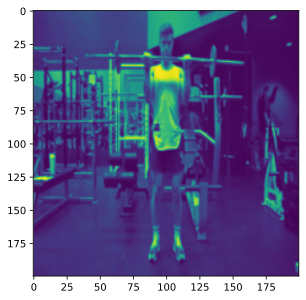

In [ ]:
_ = plt.imshow(np.asarray(X[0][0]))

#TRAIN, TEST, AND VALIDATION SET

We are going to **split** the dataset into training, test and validation sets and to create **data loaders** for each of these sets:

In [ ]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = int(0.1 * dataset_size)
validation_size =  dataset_size-(train_size+test_size)

train_dataset,test_dataset,validation_dataset = random_split(dataset, [train_size, test_size,validation_size])
train_iter = data.DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=2)
test_iter = data.DataLoader(test_dataset, batch_size=25, shuffle=False, num_workers=2)
validation_iter = data.DataLoader(validation_dataset, batch_size=25, shuffle=False, num_workers=2)

We are now going to use the following functions:

-**Evaluate_accuracy_gpu()** :

This function evaluates the accuracy of the model on a given dataset (data_iter) using a GPU (device).
It sets the model to evaluation mode, computes the accuracy, and returns the ratio of correct predictions to the total number of predictions.

-**Train()**:

This function is responsible for training the neural network.
It initializes the weights using the Xavier uniform initialization for linear and convolutional layers. It moves the model to the GPU (if available) using net.to(device). It uses stochastic gradient descent (torch.optim.SGD()) as the optimizer and cross-entropy loss (nn.CrossEntropyLoss()) as the loss function.
The training loop runs for a specified number of epochs (num_epochs).
Inside the loop, it iterates over the training data (train_iter), performs forward and backward passes, and updates the model parameters.
It also keeps track of training loss and accuracy during each epoch.
After each epoch, it **evaluates the model on the validation set** using the evaluate_accuracy_gpu() and gives the training loss, training accuracy, and validation accuracy as the output.
The animator object is used to visualize the training progress.

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization
    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Results of the model

The train function is called to train the neaural network on the training set and evaluate it on the validation set. We decided to stop after 9 epochs to prevent overfitting and we obtained the following results:

loss 0.196, train acc 0.944, val acc 0.951
721.9 examples/sec on cuda:0


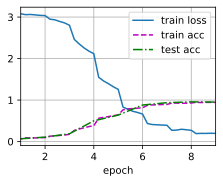

In [ ]:
lr, num_epochs = 0.05, 9

train(net, train_iter, validation_iter ,num_epochs, lr, device=d2l.try_gpu())

Results obtained:


*   Training loss: 0.196
*   Training accuracy: 94.4%
*   Validation accuracy: 95.1%

The model is learning well on the training set(as indicated by the training loss and accuracy) and it generalizes effectively on the validation set. Furthermore the training process is efficient, running at a speed of 721.9 examples per second on the specified GPU.



# ASSESSING THE PERFORMACE

Now we create a function,**evaluate_and_display_images**, to evaluate the model on a **test dataset** and display a subset of images along with their **true and predicted values**. The **display_images** function is used to visualize the images.


This is a great way to *visually inspect* how well the model is performing on specific images from the test set:

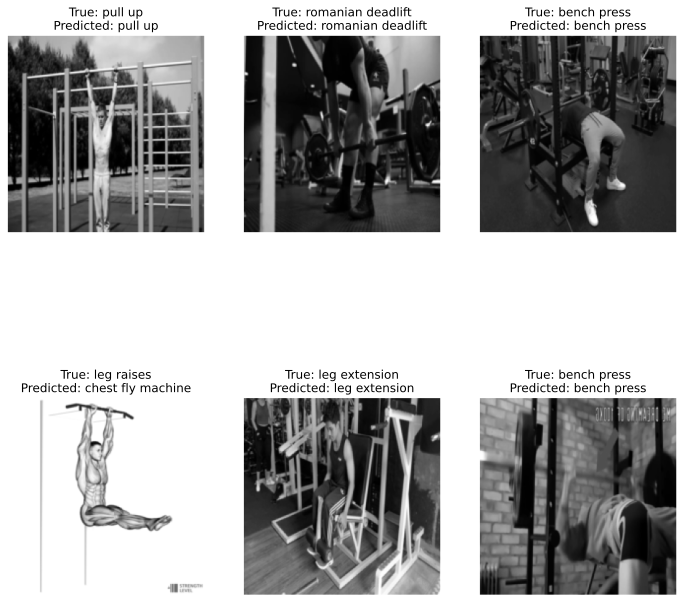

In [ ]:
def evaluate_and_display_images(net, data_iter, class_names, device=None, num_display=6):
    """Evaluate the model and display images with true and predicted values."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device


    true_values = []
    predicted_values = []
    images = []

    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        predictions = torch.argmax(y_hat, dim=1)

        for i in range(len(predictions)):
            true_values.append(class_names[y[i]])
            predicted_values.append(class_names[predictions[i]])
            images.append(X[i].cpu())

    display_images(images[:num_display], true_values[:num_display], predicted_values[:num_display])

def display_images(images, true_values, predicted_values):
    """Display images with true and predicted values."""
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(F.to_pil_image(images[i]), cmap='gray')
            ax.set_title(f'True: {true_values[i]}\nPredicted: {predicted_values[i]}')
            ax.axis('off')

    plt.show()


evaluate_and_display_images(net, test_iter, class_names, device=d2l.try_gpu(), num_display=6)


We can see that out of 6 cases, the correct exercise was predicted 5 times.

# CONFUSION MATRIX

Also for this model we want to create a confusion matrix based on the true labels and predicted labels to summarize the performance of our classification algorithm:

In [ ]:
from sklearn.metrics import confusion_matrix

device=None
if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

y_pred = []
y_true = []
# iterate over test data
for inputs, labels in test_iter:
        inputs = inputs.to(device)

        output=net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth



# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
print(f'The overall test accuracy is: {round(cf_matrix.trace()/sum(sum(cf_matrix)),3)*100}%')

The overall test accuracy is: 95.39999999999999%


The overall test accuracy is 95.39& and we are now going to display the confusion matrix:

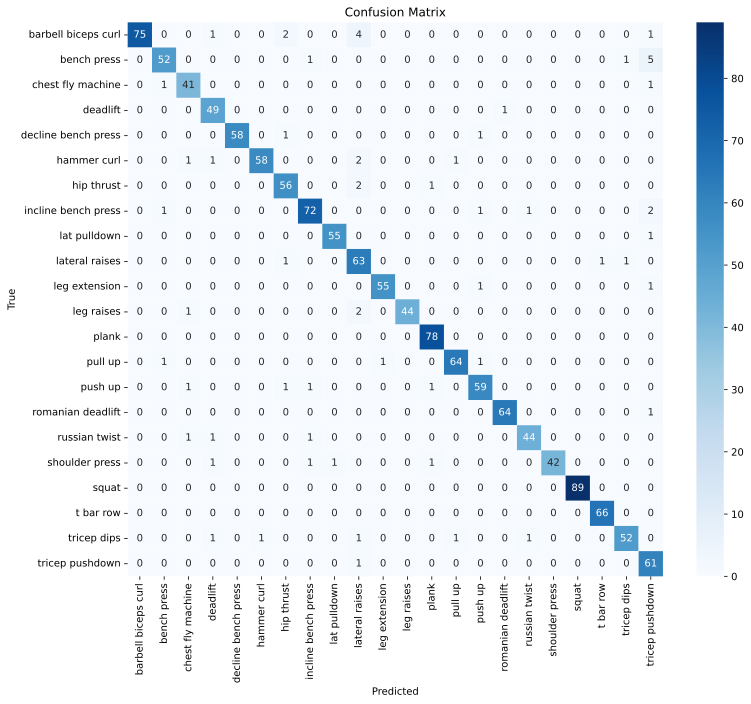

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display misclassified images

Finally we created a function, **evaluate_and_display_misclassified**, to evaluate the model on a test dataset, identify misclassified images, and display a subset of these misclassified images along with their true and predicted labels. The **display_images** function is used to visualize the images.

*This is a useful approach to visually inspect instances where your model is making mistakes.*It can provide insights into the types of errors the model is making and potentially guide further improvements or adjustments to the training process.

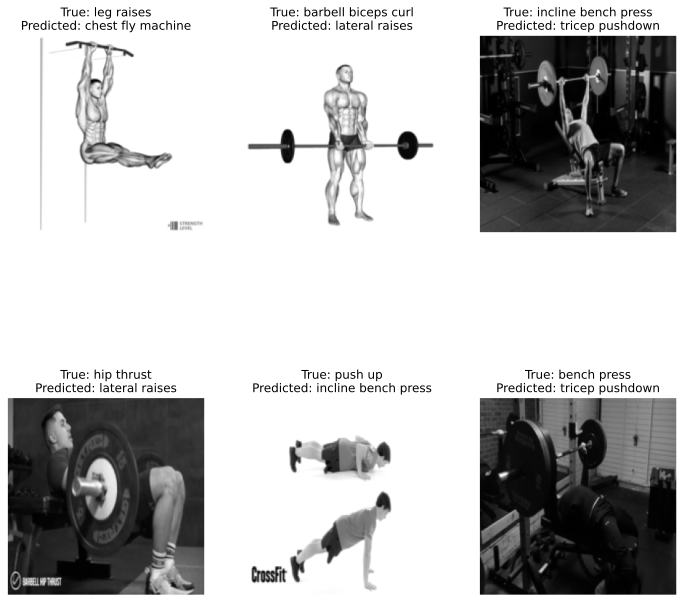

In [ ]:
def display_images(images, true_values, predicted_values):
    """Display images with true and predicted values."""
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i]
            if image.shape[0] == 1:

                image = image[0]
            ax.imshow(F.to_pil_image(image), cmap='gray')
            ax.set_title(f'True: {true_values[i]}\nPredicted: {predicted_values[i]}')
            ax.axis('off')

    plt.show()

def evaluate_and_display_misclassified(net, data_iter, class_names, device=None, num_display=10):
    """Evaluate the model and display misclassified images."""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device


    true_labels = []
    predicted_labels = []
    misclassified_images = []

    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        predictions = torch.argmax(y_hat, dim=1)

        incorrect_indices = (predictions != y).nonzero() #check for incorrectly predicted images

        for idx in incorrect_indices:
            misclassified_images.append(X[idx].cpu())
            true_labels.append(class_names[y[idx]])
            predicted_labels.append(class_names[predictions[idx]])


    display_images(misclassified_images[:num_display], true_labels[:num_display], predicted_labels[:num_display])


evaluate_and_display_misclassified(net, test_iter, class_names, device=d2l.try_gpu(), num_display=6)


For example, in the second image, the exercise predicted is 'lateral raises,' while the actual exercise was 'barbell biceps curl'; this could be attributed to the fact that in both exercises, the body position is exactly identical.

# COMPARISON OF THE TWO ARCHITECTURES

LeNet Model:


*   Training Loss: 0.642
*   Training Accuracy: 82.3%
*   Validation Accuracy: 85.1%

AlexNet Model:

*   Training Loss: 0.196
*   Training Accuracy: 94.4%
*   Validation Accuracy: 95.1%

The AlexNet model outperforms the LeNet model in terms of both training and validation accuracy. The AlexNet model achieves a significantly higher accuracy on the training set (94.4%) compared to the LeNet model (82.3%). Additionally, the validation accuracy of the AlexNet model (95.1%) is also higher than that of the LeNet model (85.1%). The lower training loss for AlexNet (0.196) compared to LeNet (0.642) further indicates that the AlexNet model is better at minimizing the error during training.

In summary, the **AlexNet model exhibits superior performance** in terms of both training and validation accuracy, suggesting that it is a more effective model for the given task compared to the LeNet model.





